<a href="https://colab.research.google.com/github/LI3ARA/FYIRP/blob/main/Notebooks/25/VQA_RAG/Evaluation/evaluation_of_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [17]:
from PIL import Image 


In [114]:
from bert_score import score

In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lisara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lisara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from bert_score import score as bert_score


In [3]:
from nlgeval import NLGEval


ModuleNotFoundError: No module named 'nlgeval'

In [3]:
from pycocoevalcap.spice.spice import Spice


In [4]:

import pandas as pd
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [5]:
from sentence_transformers import SentenceTransformer, util
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np


In [28]:
from nlgeval import NLGEval


ModuleNotFoundError: No module named 'nlgeval'

In [9]:

from bert_score import score as bert_score


In [10]:
from pycocoevalcap.spice.spice import Spice


In [11]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer


In [72]:
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer
import nltk


In [71]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
import re

In [69]:
# --- Utility Functions ---

def simple_f1(pred, truth):
    pred_tokens = normalize_text(pred).split()
    truth_tokens = normalize_text(truth).split()
    common = set(pred_tokens) & set(truth_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

def extract_reason(response):
    match = re.search(r'Reason for answer:\s*(.*)', response, re.DOTALL | re.IGNORECASE)
    return match.group(1).strip() if match else response.strip()

### code for BERTScore, METEOR, ROUGE-L, CIDEr, SPICE 

In [28]:

# Download required NLTK data
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lisara\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lisara\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
# Initialize models (one-time setup)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # For semantic similarity
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [92]:
# Compute metrics for each row
def compute_metrics(row):
    ref = row['answer']
    pred = row['response']
    
    # Tokenize for BLEU, METEOR
    ref_tokens = nltk.word_tokenize(ref.lower())
    pred_tokens = nltk.word_tokenize(pred.lower())
    
    # Compute Exact Match
    exact_match = 1 if ref == pred else 0
    
    # Compute BLEU (use 1-gram to 4-gram, equal weights)
    bleu = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))
    
    # Compute METEOR
    meteor = meteor_score([ref_tokens], pred_tokens)
    
    # Compute ROUGE-L
    rouge = scorer.score(ref, pred)['rougeL'].fmeasure
    
    # Compute CIDEr (requires list format)
    cider_obj = Cider()
    cider_score, _ = cider_obj.compute_score([{'caption': [ref]}], [pred])
    
    # Compute SPICE (slower, requires list format)
    spice_obj = Spice()
    spice_score, _ = spice_obj.compute_score([{'caption': [ref]}], [pred])
    
    # Compute BERTScore (F1)
    _, _, bert_f1 = bert_score([pred], [ref], lang='en')
    bert_f1 = bert_f1.mean().item()
    
    # Compute Semantic Similarity (SBERT)
    embeddings = sbert_model.encode([ref, pred])
    semantic_sim = np.dot(embeddings[0], embeddings[1]) / (
        np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1])
    )
    
    return {
        'exact_match': exact_match,
        'f1': rouge,  # Using ROUGE-L F1 as general F1
        'bleu': bleu,
        'rougeL': rouge,
        'meteor': meteor,
        'cider': cider_score,
        'spice': spice_score,
        'bertscore_f1': bert_f1,
        'semantic_sim': semantic_sim
    }

def get_evals_for_df(df):
    # Apply to each row (this may take time for large DataFrames)
    metrics = df.apply(compute_metrics, axis=1, result_type='expand')

    # Add metrics back to the original DataFrame
    df = pd.concat([df, metrics], axis=1)

    # Compute mean of all metrics
    mean_metrics = {
        "Exact Match": df['exact_match'].mean(),
        "F1 Score": df['f1'].mean(),
        "BLEU": df['bleu'].mean(),
        "ROUGE-L": df['rougeL'].mean(),
        "METEOR": df['meteor'].mean(),
        "CIDEr": np.mean(df['cider']),
        "SPICE": np.mean(df['spice']),
        "BERTScore (F1)": df['bertscore_f1'].mean(),
        "Semantic Similarity (SBERT)": df['semantic_sim'].mean()
    }
    return df, mean_metrics


In [83]:

#  For the eval of sccore - image and custom only
def evaluate_metrics(df):
    """
    df: DataFrame with two columns:
        - 'answer': ground truth/reference
        - 'response': model output
    """
    # BERTScore
    P, R, F1 = bert_score(df['response'].tolist(), df['answer'].tolist(), lang='en', model_type='microsoft/deberta-xlarge-mnli')
    df['bertscore_f1'] = F1.numpy()

    # NLGEval (METEOR, ROUGE-L, CIDEr)
    nlgeval = NLGEval(no_skipthoughts=True, no_glove=True)
    meteor, rouge_l, cider = [], [], []

    for ref, hyp in zip(df['answer'], df['response']):
        scores = nlgeval.compute_individual_metrics([ref], hyp)
        meteor.append(scores['METEOR'])
        rouge_l.append(scores['ROUGE_L'])
        cider.append(scores['CIDEr'])

    df['meteor'] = meteor
    df['rouge_l'] = rouge_l
    df['cider'] = cider

    # SPICE (optional — slower)
    gts = {i: [ref] for i, ref in enumerate(df['answer'])}
    res = {i: [hyp] for i, hyp in enumerate(df['response'])}
    spice = Spice()
    spice_score, _ = spice.compute_score(gts, res)
    df['spice'] = spice_score if isinstance(spice_score, list) else [spice_score] * len(df)

    # Summary
    summary = {
        'BERTScore (F1)': df['bertscore_f1'].mean(),
        'METEOR': df['meteor'].mean(),
        'ROUGE-L': df['rouge_l'].mean(),
        'CIDEr': df['cider'].mean(),
        'SPICE': df['spice'].mean(),
    }

    print("\n Evaluation Summary:")
    for k, v in summary.items():
        print(f"{k}: {v:.4f}")

    return df, summary


In [84]:

def get_evals_img_onlyt(df): # If exact scores also needed
    # Exact Match
    df['exact_match'] = df.apply(
        lambda row: normalize_text(row['response']) == normalize_text(row['answer']),
        axis=1
    )

    # F1
    df['f1'] = df.apply(
        lambda row: simple_f1(row['response'], row['answer']),
        axis=1
    )

    # BLEU
    smoothie = SmoothingFunction().method4
    df['bleu'] = df.apply(
        lambda row: sentence_bleu(
            [normalize_text(row['answer']).split()],
            normalize_text(row['response']).split(),
            smoothing_function=smoothie
        ), axis=1
    )

    # ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    df['rougeL'] = df.apply(
        lambda row: scorer.score(str(row['answer']), str(row['response']))['rougeL'].fmeasure,
        axis=1
    )

    # METEOR & CIDEr
    nlgeval = NLGEval(no_skipthoughts=True, no_glove=True)
    meteor, cider = [], []
    for ref, hyp in zip(df['answer'], df['response']):
        scores = nlgeval.compute_individual_metrics([ref], hyp)
        meteor.append(scores['METEOR'])
        cider.append(scores['CIDEr'])
    df['meteor'] = meteor
    df['cider'] = cider

    # SPICE
    gts = {i: [ref] for i, ref in enumerate(df['answer'])}
    res = {i: [hyp] for i, hyp in enumerate(df['response'])}
    spice = Spice()
    spice_score, _ = spice.compute_score(gts, res)
    df['spice'] = spice_score if isinstance(spice_score, list) else [spice_score] * len(df)

    # BERTScore
    P, R, F1 = bert_score(df['response'].tolist(), df['answer'].tolist(),
                          lang='en', model_type='microsoft/deberta-xlarge-mnli')
    df['bertscore_f1'] = F1.numpy()

    # SentenceBERT Semantic Similarity
    sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    emb_gold = sbert_model.encode(df['answer'].tolist(), convert_to_tensor=True)
    emb_bot = sbert_model.encode(df['response'].tolist(), convert_to_tensor=True)
    cos_sim = util.cos_sim(emb_gold, emb_bot).diagonal().cpu().numpy()
    df['semantic_sim'] = cos_sim

    # Summary
    summary = {
        "Exact Match": df['exact_match'].mean(),
        "F1 Score": df['f1'].mean(),
        "BLEU": df['bleu'].mean(),
        "ROUGE-L": df['rougeL'].mean(),
        "METEOR": df['meteor'].mean(),
        "CIDEr": np.mean(df['cider']),
        "SPICE": np.mean(df['spice']),
        "BERTScore (F1)": df['bertscore_f1'].mean(),
        "Semantic Similarity (SBERT)": df['semantic_sim'].mean(),
    }

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.bar(summary.keys(), summary.values(), color='skyblue')
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Evaluation Metrics Summary")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print(" Evaluation Summary:")
    for metric, score in summary.items():
        print(f"{metric}: {score:.4f}")

    return df, summary


In [33]:
# --- Load Data ---
def get_evals_text(df):
    # df = pd.read_csv("merged_for_evaluation.csv")  # Replace with your actual merged dataset
    # If you have a column like 'cleaned_response_raw', extract reason into 'cleaned_response'
    df['cleaned_response'] = df['cleaned_response'].apply(extract_reason)

    # --- Metrics ---

    # Exact Match
    df['exact_match'] = df.apply(
        lambda row: normalize_text(row['cleaned_response']) == normalize_text(row['answer']),
        axis=1
    )

    # F1
    df['f1'] = df.apply(
        lambda row: simple_f1(row['cleaned_response'], row['answer']),
        axis=1
    )

    # BLEU
    smoothie = SmoothingFunction().method4
    df['bleu'] = df.apply(
        lambda row: sentence_bleu([normalize_text(row['answer']).split()],
                                normalize_text(row['cleaned_response']).split(),
                                smoothing_function=smoothie), axis=1
    )

    # ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    df['rougeL'] = df.apply(
        lambda row: scorer.score(row['answer'], row['cleaned_response'])['rougeL'].fmeasure,
        axis=1
    )

    # Semantic Similarity (SentenceBERT)
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    emb_gold = model.encode(df['answer'].tolist(), convert_to_tensor=True)
    emb_bot = model.encode(df['cleaned_response'].tolist(), convert_to_tensor=True)
    cos_sim = util.cos_sim(emb_gold, emb_bot).diagonal().cpu().numpy()
    df['semantic_sim'] = cos_sim

    # --- Summary ---
    summary = {
        "Exact Match": df['exact_match'].mean(),
        "F1 Score": df['f1'].mean(),
        "BLEU": df['bleu'].mean(),
        "ROUGE-L": df['rougeL'].mean(),
        "Semantic Similarity": df['semantic_sim'].mean(),
    }
        # Visualization
    plt.figure(figsize=(10, 6))
    plt.bar(summary.keys(), summary.values(), color='skyblue')
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Evaluation Metrics Summary")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Evaluation Summary:")
    for metric, score in summary.items():
        print(f"{metric}: {score:.4f}")
        
    return df, summary

In [85]:

# --- Load Data ---
def get_evals_img_onlyt(df):
    # df = pd.read_csv("merged_for_evaluation.csv")  # Replace with your actual merged dataset
    # If you have a column like 'cleaned_response_raw', extract reason into 'cleaned_response'
    # df['response'] = df['response'].apply(extract_reason)

    # --- Metrics ---

    # Exact Match
    df['exact_match'] = df.apply(
        lambda row: normalize_text(row['response']) == normalize_text(row['answer']),
        axis=1
    )

    # F1
    df['f1'] = df.apply(
        lambda row: simple_f1(row['response'], row['answer']),
        axis=1
    )

    # BLEU
    smoothie = SmoothingFunction().method4
    df['bleu'] = df.apply(
        lambda row: sentence_bleu([normalize_text(row['answer']).split()],
                                normalize_text(row['response']).split(),
                                smoothing_function=smoothie), axis=1
    )

    # ROUGE-L
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    df['rougeL'] = df.apply(
        lambda row: scorer.score(str(row['answer']), str(row['response']))['rougeL'].fmeasure,
        axis=1
    )

    # Semantic Similarity (SentenceBERT)
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    emb_gold = model.encode(df['answer'].tolist(), convert_to_tensor=True)
    emb_bot = model.encode(df['response'].tolist(), convert_to_tensor=True)
    cos_sim = util.cos_sim(emb_gold, emb_bot).diagonal().cpu().numpy()
    df['semantic_sim'] = cos_sim

    # --- Summary ---
    summary = {
        "Exact Match": df['exact_match'].mean(),
        "F1 Score": df['f1'].mean(),
        "BLEU": df['bleu'].mean(),
        "ROUGE-L": df['rougeL'].mean(),
        "Semantic Similarity": df['semantic_sim'].mean(),
    }
        # Visualization
    plt.figure(figsize=(10, 6))
    plt.bar(summary.keys(), summary.values(), color='skyblue')
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.title("Evaluation Metrics Summary")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Evaluation Summary:")
    for metric, score in summary.items():
        print(f"{metric}: {score:.4f}")
        
    return df, summary


---

# Code Running

In [73]:
# Since there was no index column for ground truth df(to be used in)
text_gt = index_add_to_gold_truth_df(gold_truth_csv_path = '../../../../Data/VisDoM-main/spiqa/spiqa.csv')
text_gt.head(3)

,index,q_id,doc_id,old_question,answer,doc_path,documents,rationale,reference_figure,paper_title,paper_abstract,caption,question
0,0,spiqa_0,1805.01216v3,How does Figure 9 in the paper *Disentangling Language and Knowledge in Task-Oriented Dialogs* illustrate the transformation of point-of-interest properties between the original and pre-processed SMD Navigate datasets?,"\n\nThe pre-processed SMD Navigate data combines all the properties (such as distance, address) of a point of interest (POI) into a single subject with the object being ""poi"". The original data had separate entries for each property.",1805.01216v3.pdf,"['1805.01216v3.pdf', '1705.09296v2.pdf', '1705.02946v3.pdf', '1803.04572v2.pdf', '1707.06320v2.pdf', '1809.00263v5.pdf', '1804.07849v4.pdf', '1709.02755v5.pdf', '1812.06589v2.pdf', '1710.01507v4.pdf', '1708.05239v3.pdf', '1705.02798v6.pdf', '1812.00108v4.pdf', '1708.03797v1.pdf']","\n\nThe figure shows two tables. The top table is the original SMD Navigate data, and the bottom table is the pre-processed data. In the original data, each property of a POI has its own entry in the table. For example, the POI ""the_westin"" has three entries: one for its distance, one for its traffic information, and one for its address. In the pre-processed data, all of these properties are combined into a single entry with the subject ""2 miles moderate_traffic rest_stop"" and the object ""poi"".",1805.01216v3-Figure9-1.png,Disentangling Language and Knowledge in Task-Oriented Dialogs,"The Knowledge Base (KB) used for real-world applications, such as booking a\nmovie or restaurant reservation, keeps changing over time. End-to-end neural\nnetworks trained for these task-oriented dialogs are expected to be immune to\nany changes in the KB. However, existing approaches breakdown when asked to\nhandle such changes. We propose an encoder-decoder architecture (BoSsNet) with\na novel Bag-of-Sequences (BoSs) memory, which facilitates the disentangled\nlearning of the response's language model and its knowledge incorporation.\nConsequently, the KB can be modified with new knowledge without a drop in\ninterpretability. We find that BoSsNet outperforms state-of-the-art models,\nwith considerable improvements (> 10\%) on bAbI OOV test sets and other\nhuman-human datasets. We also systematically modify existing datasets to\nmeasure disentanglement and show BoSsNet to be robust to KB modifications.",Figure 9: Pre-processing of SMD Navigate data used in Mem2Seq paper,\n\nWhat is the difference between the original and pre-processed SMD Navigate data?
1,1,spiqa_1,1805.07567v2,"Referring to the figure that illustrates the impact of increasing β2 on precision and recall in the salient object detection model optimized by the FLoss function, how does increasing β2 influence the trade-off between precision and recall?",\n\nIncreasing the value of β2 decreases the precision and increases the recall of the model.,1805.07567v2.pdf,"['1805.07567v2.pdf', '1802.07222v1.pdf', '1811.02553v4.pdf', '1705.07384v2.pdf', '1707.08608v3.pdf', '1703.10730v2.pdf', '1710.01507v4.pdf', '1804.07849v4.pdf', '1811.08481v2.pdf', '1804.05995v2.pdf']","\n\nThe figure shows that the precision curve (red) slopes downward as β2 increases, while the recall curve (green) slopes upward. This indicates that increasing β2 leads to a decrease in precision and an increase in recall.",1805.07567v2-Figure6-1.png,Optimizing the F-measure for Threshold-free Salient Object Detection,"Current CNN-based solutions to salient object detection (SOD) mainly rely on\nthe optimization of cross-entropy loss (CELoss). Then the quality of detected\nsaliency maps is often evaluated in terms of F-measure. In this paper, we\ninvestigate an interesting issue: can we consistently use the F-measure\nformulation in both training and evaluation for SOD? By reformulating the\nstandard F-measure we propose the relaxed F-measure which is differentiable\nw.r.t the posterior and can be easily appended to the bac

## For text only evaluation

In [63]:
# Concatenate answer csv files
merged_text_answers = get_merged_csvs(folder_path = '../../../../Eval_outputs/SPIQA/text_only_vidsom', label='text_only_mistral_visdom')

In [64]:
merged_text_answers.head(3)

,index,question,response
0,0,How does Figure 9 in the paper *Disentangling Language and Knowledge in Task-Oriented Dialogs* illustrate the transformation of point-of-interest properties between the original and pre-processed SMD Navigate datasets?,"Answered: Yes\nReason for answer: Figure 9 in the paper shows two bar graphs side by side, representing the distribution of point-of-interest properties (POI) before and after preprocessing in the SMD Navigate dataset. The figure allows comparison of the transformation in POI properties between the original and pre-processed datasets, providing insights into how the preprocessing affected the distribution of properties. However, without further context on specific details about the bar graphs or the POI properties themselves, it is not possible to provide a detailed analysis of the transformation illustrated by Figure 9."
1,1,"Referring to the figure that illustrates the impact of increasing β2 on precision and recall in the salient object detection model optimized by the FLoss function, how does increasing β2 influence the trade-off between precision and recall?",Answered: Yes\nReason for answer: Increasing β2 in the salient object detection model optimized by the FLoss function causes a shift towards higher precision at the cost of recall. This means that the model becomes better at correctly identifying true positives (relevant items) while potentially missing some (lower recall).
2,2,"How does Figure 1 in the paper illustrate the difference between 2-D and 1-D cake division, specifically showing how geometric constraints in 2-D (like rectangularity) can result in unallocated portions of the cake, unlike in 1-D division?","Answer: Yes\nReason for answer: Figure 1 in the paper illustrates two different methods of cake division: 1-D and 2-D. In the 1-D case, a single line is used to divide the cake into equal portions, ensuring that no part goes unallocated. In contrast, the 2-D case uses a square or rectangular grid to divide the cake. Due to geometric constraints, it may not be possible to perfectly divide the cake into equal portions without leaving some unallocated pieces when using this method, as shown in the figure. This is particularly true for non-rectangular shapes."


In [65]:
# The answers and the gt files are merged to one dataframe for easy access
df_merged = merge_dfs_by(df_gold=text_gt ,df_bot=merged_text_answers, index='index')

In [66]:
df_merged.head(2)

,index,q_id,doc_id,old_question,answer,doc_path,documents,rationale,reference_figure,paper_title,paper_abstract,caption,question_x,question_y,response
0,0,spiqa_0,1805.01216v3,How does Figure 9 in the paper *Disentangling Language and Knowledge in Task-Oriented Dialogs* illustrate the transformation of point-of-interest properties between the original and pre-processed SMD Navigate datasets?,"\n\nThe pre-processed SMD Navigate data combines all the properties (such as distance, address) of a point of interest (POI) into a single subject with the object being ""poi"". The original data had separate entries for each property.",1805.01216v3.pdf,"['1805.01216v3.pdf', '1705.09296v2.pdf', '1705.02946v3.pdf', '1803.04572v2.pdf', '1707.06320v2.pdf', '1809.00263v5.pdf', '1804.07849v4.pdf', '1709.02755v5.pdf', '1812.06589v2.pdf', '1710.01507v4.pdf', '1708.05239v3.pdf', '1705.02798v6.pdf', '1812.00108v4.pdf', '1708.03797v1.pdf']","\n\nThe figure shows two tables. The top table is the original SMD Navigate data, and the bottom table is the pre-processed data. In the original data, each property of a POI has its own entry in the table. For example, the POI ""the_westin"" has three entries: one for its distance, one for its traffic information, and one for its address. In the pre-processed data, all of these properties are combined into a single entry with the subject ""2 miles moderate_traffic rest_stop"" and the object ""poi"".",1805.01216v3-Figure9-1.png,Disentangling Language and Knowledge in Task-Oriented Dialogs,"The Knowledge Base (KB) used for real-world applications, such as booking a\nmovie or restaurant reservation, keeps changing over time. End-to-end neural\nnetworks trained for these task-oriented dialogs are expected to be immune to\nany changes in the KB. However, existing approaches breakdown when asked to\nhandle such changes. We propose an encoder-decoder architecture (BoSsNet) with\na novel Bag-of-Sequences (BoSs) memory, which facilitates the disentangled\nlearning of the response's language model and its knowledge incorporation.\nConsequently, the KB can be modified with new knowledge without a drop in\ninterpretability. We find that BoSsNet outperforms state-of-the-art models,\nwith considerable improvements (> 10\%) on bAbI OOV test sets and other\nhuman-human datasets. We also systematically modify existing datasets to\nmeasure disentanglement and show BoSsNet to be robust to KB modifications.",Figure 9: Pre-processing of SMD Navigate data used in Mem2Seq paper,\n\nWhat is the difference between the original and pre-processed SMD Navigate data?,How does Figure 9 in the paper *Disentangling Language and Knowledge in Task-Oriented Dialogs* illustrate the transformation of point-of-interest properties between the original and pre-processed SMD Navigate datasets?,"Answered: Yes\nReason for answer: Figure 9 in the paper shows two bar graphs side by side, representing the distribution of point-of-interest properties (POI) before and after preprocessing in the SMD Navigate dataset. The figure allows comparison of the transformation in POI properties between the original and pre-processed datasets, providing insights into how the preprocessing affected the distribution of properties. However, without further context on specific details about the bar graphs or the POI properties themselves, it is not possible to provide a detailed analysis of the transformation illustrated by Figure 9."
1,1,spiqa_1,1805.07567v2,"Referring to the figure that illustrates the impact of increasing β2 on precision and recall in the salient object detection model optimized by the FLoss function, how does increasing β2 influence the trade-off between precision and recall?",\n\nIncreasing the value of β2 decreases the precision and increases the recall of the model.,1805.07567v2.pdf,"['1805.07567v2.pdf', '1802.07222v1.pdf', '1811.02553v4.pdf', '1705.07384v2.pdf', '1707.08608v3.pdf', '1703.10730v2.pdf', '1710.01507v4.pdf', '1804.07849v4.pdf', '1811.0

In [67]:
df_merged.rename({'response':'raw_response'}, inplace=True, axis=1)
# df_merged.head(2)

In [74]:
df_merged['response'] = df_merged['raw_response'].apply(extract_reason)

In [ ]:
df_merged['exact_match'] = df_merged.apply(
    lambda row: normalize_text(row['cleaned_response']) == normalize_text(row['answer']),
    axis=1
)


In [ ]:
df_merged['f1'] = df_merged.apply(
    lambda row: simple_f1(row['cleaned_response'], row['answer']),
    axis=1
)

In [ ]:
print_summary_scores(df_merged=df_merged)

In [ ]:
# df_merged['answered_flag'] = df_merged['response'].apply(extract_answer_flag)

In [ ]:
# df_merged['answered_flag'].nunique()

1

In [93]:
df_merged, text_only_summary =get_evals_for_df(df_merged)

NameError: name 'scorer' is not defined

---

## For Image only evaluation

In [ ]:
# Concatenate answer csv files
merged_img_answers = get_merged_csvs(folder_path = '../../../../Eval_outputs/SPIQA/vision_only', label='vision_only_visdom')
merged_img_answers.head(3)


In [12]:
both_df = pd.read_csv("../../../../Data/spiqa_eval/agent_pipeline_batches/output/final_answer_batch_0_10.csv")

In [13]:
llava_only_df = pd.read_csv("../../../../Data/spiqa_eval/llava_only/llava_generated_batch_0_10.csv")
mistral_only_df = pd.read_csv("../../../../Data/spiqa_eval/mistral_only/mistral_generated_batch_0_10.csv")

In [14]:
both_df.columns

Index(['q_id', 'doc_id', 'question', 'caption', 'true_answer', 'final_answer',
       'vision_used', 'sub_question', 'vision_answer'],
      dtype='object')

In [15]:
llava_only_df.columns

Index(['q_id', 'doc_id', 'question', 'true_answer', 'generated_answer',
       'reference_figure', 'caption'],
      dtype='object')

In [ ]:
both_df

,q_id,doc_id,question,caption,true_answer,final_answer,vision_used,sub_question,vision_answer
0,spiqa_0,1805.01216v3,\n\nWhat is the difference between the origin...,Figure 9: Pre-processing of SMD Navigate data ...,\n\nThe pre-processed SMD Navigate data combi...,The original SMD Navigate data consists of raw...,True,What are the steps involved in pre-processing ...,The steps involved in pre-processing of SMD Na...
1,spiqa_0,1805.01216v3,\n\nWhat is the difference between the origin...,Figure 9: Pre-processing of SMD Navigate data ...,\n\nThe pre-processed SMD Navigate data combi...,The difference between the original and pre-pr...,True,What changes or transformations occurred durin...,The pre-processing of SMD Navigate data involv...
2,spiqa_6,1706.04284v3,Which denoiser performs the best on the sheep...,Two semantic segmentation examples from Pascal...,The denoiser trained with the classification ...,"Based on the given examples, it appears that t...",True,By comparing the segmentation label maps of th...,(d)
3,spiqa_7,1901.00398v2,Which type of review was more accurately iden...,Figure 2: Accuracy of human evaluators on indi...,The human evaluators were more accurate at ide...,The figure provided does not contain informati...,True,To determine whether human evaluators more acc...,No


In [ ]:
mistral_only_df

,q_id,doc_id,question,true_answer,generated_answer,reference_figure,caption
0,spiqa_0,1805.01216v3,\n\nWhat is the difference between the origin...,\n\nThe pre-processed SMD Navigate data combi...,The caption doesn't provide specific details a...,1805.01216v3-Figure9-1.png,Figure 9: Pre-processing of SMD Navigate data ...
1,spiqa_1,1805.07567v2,\n\nWhat is the effect of increasing the valu...,\n\nIncreasing the value of β2 decreases the ...,The increase in the value of β2 results in a d...,1805.07567v2-Figure6-1.png,"Precision, Recall, F-measure of model trained ..."
2,spiqa_2,1603.00286v5,\n\nWhy does the author state that there is a...,"\n\nIn 2-D division, there may be unallocated...",The caption does not explicitly state a qualit...,1603.00286v5-Figure1-1.png,"Fig. 1 With geometric constraints, an efficien..."
3,spiqa_3,1805.06431v4,How does the performance of ChoiceNet compare...,ChoiceNet generally performs well compared to ...,"Based on the provided caption, the test accura...",1805.06431v4-Table2-1.png,Table 2: Test accuracies on the CIFAR-10 datas...
4,spiqa_4,1802.07459v2,How many negative samples are there in the tr...,"There are approximately 9,719 negative samples...",The given caption does not provide information...,1802.07459v2-Table1-1.png,Table 1: Description of evaluation datasets.
5,spiqa_5,1811.09393v4,What is the role of the warped triplets in th...,The warped triplets provide additional inform...,"In the context of the captions provided, the C...",1811.09393v4-Figure4-1.png,a) The frame-recurrent VSR Generator. b) Condi...
6,spiqa_6,1706.04284v3,Which denoiser performs the best on the sheep...,The denoiser trained with the classification ...,It is not explicitly stated in the caption whi...,1706.04284v3-Figure5-1.png,Two semantic segmentation examples from Pascal...
7,spiqa_7,1901.00398v2,Which type of review was more accurately iden...,The human evaluators were more accurate at ide...,The caption does not provide information about...,1901.00398v2-Figure2-1.png,Figure 2: Accuracy of human evaluators on indi...
8,spiqa_8,1709.02755v5,"According to Table 1 and the passage, how does...",The SRU model outperforms the LSTM model in bo...,The SRU (Self-attentive Recurrent Unit) model ...,1709.02755v5-Table2-1.png,Table 2: Exact match (EM) and F1 scores of var...
9,spiqa_9,1804.07849v4,"According to the ablation experiments, which f...",Morphological modeling with LSTMs contributes ...,Without specific numbers or details provided i...,1804.07849v4-Table2-1.png,Table 2: Ablation of the best model on Penn WSJ.


In [ ]:
llava_only_df

,q_id,doc_id,question,true_answer,generated_answer,reference_figure,caption
0,spiqa_0,1805.01216v3,\n\nWhat is the difference between the origin...,\n\nThe pre-processed SMD Navigate data combi...,The original SMD Navigate data consists of two...,1805.01216v3-Figure9-1.png,Figure 9: Pre-processing of SMD Navigate data ...
1,spiqa_1,1805.07567v2,\n\nWhat is the effect of increasing the valu...,\n\nIncreasing the value of β2 decreases the ...,"In the image, there's a graph showing the impa...",1805.07567v2-Figure6-1.png,"Precision, Recall, F-measure of model trained ..."
2,spiqa_2,1603.00286v5,\n\nWhy does the author state that there is a...,"\n\nIn 2-D division, there may be unallocated...",The author states that there is a qualitative ...,1603.00286v5-Figure1-1.png,"Fig. 1 With geometric constraints, an efficien..."
3,spiqa_3,1805.06431v4,How does the performance of ChoiceNet compare...,ChoiceNet generally performs well compared to ...,ChoiceNet is a deep learning model that perfor...,1805.06431v4-Table2-1.png,Table 2: Test accuracies on the CIFAR-10 datas...
4,spiqa_4,1802.07459v2,How many negative samples are there in the tr...,"There are approximately 9,719 negative samples...",The number of negative samples in the training...,1802.07459v2-Table1-1.png,Table 1: Description of evaluation datasets.
5,spiqa_5,1811.09393v4,What is the role of the warped triplets in th...,The warped triplets provide additional inform...,"In the diagram, warped triplets are used as co...",1811.09393v4-Figure4-1.png,a) The frame-recurrent VSR Generator. b) Condi...
6,spiqa_6,1706.04284v3,Which denoiser performs the best on the sheep...,The denoiser trained with the classification ...,The denoiser that performs the best in this ca...,1706.04284v3-Figure5-1.png,Two semantic segmentation examples from Pascal...
7,spiqa_7,1901.00398v2,Which type of review was more accurately iden...,The human evaluators were more accurate at ide...,Human-written reviews were found to be more ac...,1901.00398v2-Figure2-1.png,Figure 2: Accuracy of human evaluators on indi...
8,spiqa_8,1709.02755v5,"According to Table 1 and the passage, how does...",The SRU model outperforms the LSTM model in bo...,The SRU model outperforms the LSTM model with ...,1709.02755v5-Table2-1.png,Table 2: Exact match (EM) and F1 scores of var...
9,spiqa_9,1804.07849v4,"According to the ablation experiments, which f...",Morphological modeling with LSTMs contributes ...,"According to the table, it appears that the no...",1804.07849v4-Table2-1.png,Table 2: Ablation of the best model on Penn WSJ.


# Background work

## Merge the evaluation results to one df

In [43]:
def get_merged_csvs(folder_path,label):
  csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
  merged_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in csv_files], ignore_index = True)
  return merged_df

## Index column add to gold truth df

In [53]:
def index_add_to_gold_truth_df(gold_truth_csv_path):

    df_gold = pd.read_csv(gold_truth_csv_path)

    df_gold.reset_index(drop=True, inplace=True)
    df_gold['index'] = df_gold.index

    # Move the index column to the front
    cols = ['index'] + [col for col  in df_gold.columns if col!='index']
    df_gold = df_gold[cols]

    return df_gold

## Merge gold Truth with Bot responeses

In [57]:
import pandas as pd

def merge_dfs_by(df_gold, df_bot,index='index'):
        # Merge on 'index'
    df_merged = pd.merge(df_gold, df_bot, on=index, how='inner')

    # Optional: Save merged file
    df_merged.to_csv("merged_for_evaluation.csv", index=False)
    
    return df_merged


## Only for text responses: Extract answers from template

In [19]:
import re

def extract_reason(response):
    # Find the reason part after "Reason for answer:"
    match = re.search(r'Reason for answer:\s*(.*)', response, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return response.strip()  # fallback to full text if pattern not found

In [20]:
def extract_answer_flag(response): # evaluates answered or not
    match = re.search(r'Answered or not:\s*(Yes|No)', response, re.IGNORECASE)
    return match.group(1).strip().lower() if match else None

## Evaluation Pipeline

### Code for EM and F1

In [49]:
from sklearn.metrics import f1_score
import numpy as np

# Preprocessing helper (optional, customize as needed)

def normalize_text(s):
    if not isinstance(s, str):
        s = str(s) if s is not None else ""
    return ''.join(e.lower() for e in s if e.isalnum() or e.isspace()).strip()



In [22]:

# Simple F1 (based on word overlap, not sklearn's classifier-based F1)
def simple_f1(pred, truth):
    pred_tokens = normalize_text(pred).split()
    truth_tokens = normalize_text(truth).split()
    common = set(pred_tokens) & set(truth_tokens)
    if not common:
        return 0.0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return 2 * precision * recall / (precision + recall)

# df_merged['f1'] = df_merged.apply(
#     lambda row: simple_f1(row['bot_response'], row['answer']),
#     axis=1
# )

In [87]:
def print_summary_scores(df_merged): 
    # Summary scores
    em_score = df_merged['exact_match'].mean()
    avg_f1 = df_merged['f1'].mean()

    print(f"Exact Match: {em_score:.4f}")
    print(f"Average F1: {avg_f1:.4f}")


### Code for BLEU/ROGUE and Semantic similarity

In [24]:
# ! pip install nltk rouge-score sentence-transformers

In [ ]:
# Since there was no index column for ground truth df(to be used in merging)
text_gt = index_add_to_gold_truth_df(gold_truth_csv_path = '../../../../Data/VisDoM-main/spiqa/spiqa.csv')
text_gt.head(3)


In [ ]:
# The answers and the gt files are merged to one dataframe for easy access
df_merged_v = merge_dfs_by(df_gold=text_gt ,df_bot=merged_img_answers, index='index')
df_merged_v.head(2)


In [56]:
s= "kusdfuuh  sdfuh WERv 234 sdf.? wf"
''.join(e.lower() for e in s if e.isalnum() or e.isspace()).strip()

'kusdfuuh  sdfuh werv 234 sdf wf'

In [59]:
df_merged_v.apply(
    lambda row: normalize_text(row['response']) == normalize_text(row['answer']),
    axis=1
)

0      False
1      False
2      False
3      False
4      False
       ...  
611    False
612    False
613    False
614    False
615    False
Length: 616, dtype: bool

In [58]:
# df_merged['cleaned_response'] = df_merged['response'].apply(extract_reason)
df_merged_v['exact_match'] = df_merged_v.apply(
    lambda row: normalize_text(row['response']) == normalize_text(row['answer']),
    axis=1
)


In [59]:

df_merged_v['f1'] = df_merged_v.apply(
    lambda row: simple_f1(row['response'], row['answer']),
    axis=1
)
print_summary_scores(df_merged=df_merged_v)
# df_merged['answered_flag'] = df_merged['response'].apply(extract_answer_flag)
# df_merged['answered_flag'].nunique()


Exact Match: 0.0114
Average F1: 0.1963


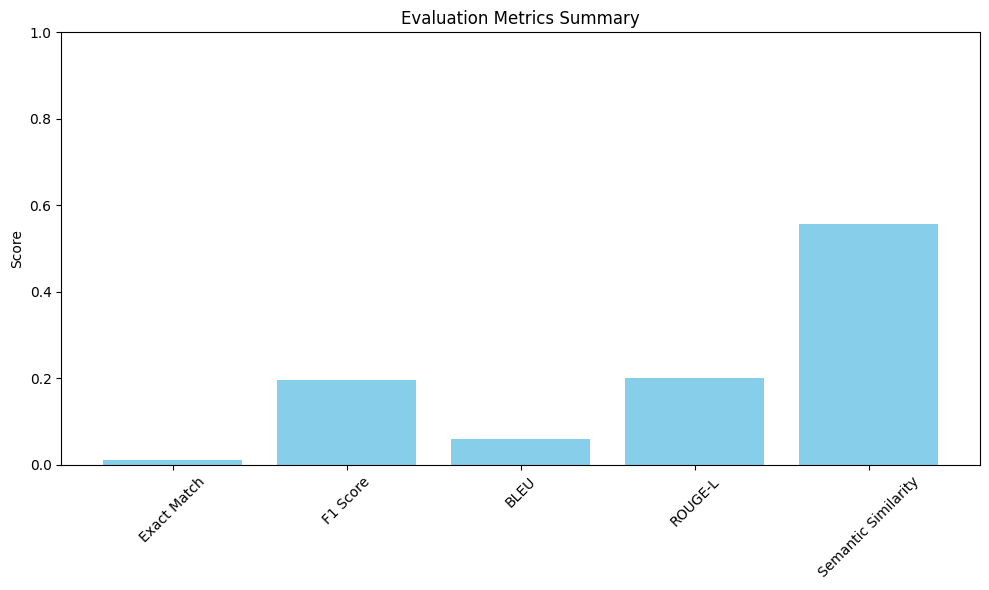

Evaluation Summary:
Exact Match: 0.0114
F1 Score: 0.1963
BLEU: 0.0605
ROUGE-L: 0.2001
Semantic Similarity: 0.5565


In [60]:
df_merged_v, vis_only_summary =get_evals_img_onlyt(df_merged_v)

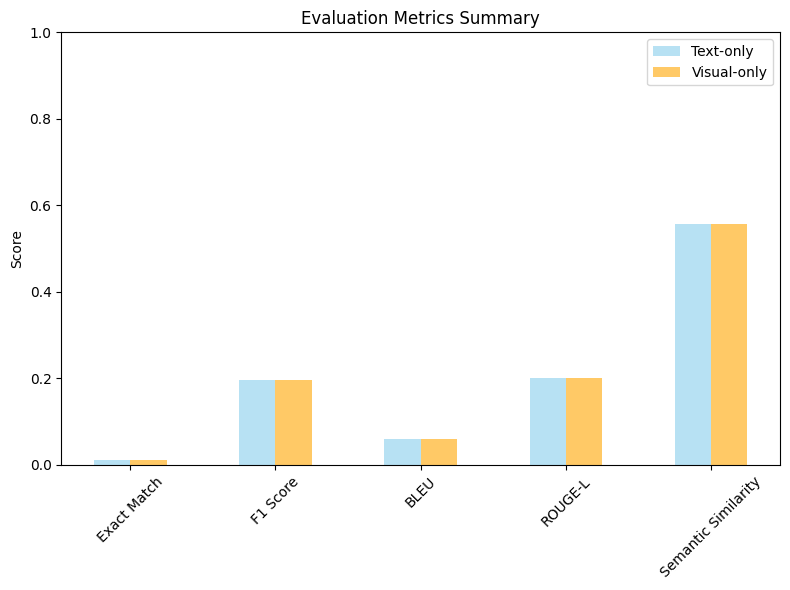

In [ ]:
# Example data
labels = list(text_only_summary.keys())
x = np.arange(len(labels))  # label positions
width = 0.25  # width of each bar

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, text_only_summary.values(), width, label='Text-only', color='skyblue', alpha=0.6)
plt.bar(x + width/2, vis_only_summary.values(), width, label='Visual-only', color='orange', alpha=0.6)

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Evaluation Metrics Summary")
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Our code

In [44]:
merged_custom = get_merged_csvs("../../../../Eval_outputs/SPIQA/ReAlignQA", label="custom")
merged_custom.head(2)

,index,question,caption,image,response
0,0,How does Figure 9 in the paper *Disentangling Language and Knowledge in Task-Oriented Dialogs* illustrate the transformation of point-of-interest properties between the original and pre-processed SMD Navigate datasets?,Figure 9: Pre-processing of SMD Navigate data used in Mem2Seq paper,../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images\1805.01216v3\1805.01216v3-Figure9-1.png,"Figure 9 in the paper ""Disentangling Language and Knowledge in Task-Oriented Dialogs"" depicts the transformation process between the original and pre-processed SMD Navigate datasets. The visualization is presented as a table with two columns - one for the ""Original SMD Navigate Dataset"" and another for the ""Preprocessed SMD Navigate Dataset."" Each column contains several rows of words or phrases, with an arrow pointing from the left to the right. This visual representation illustrates how pre-processing simplifies and focuses on essential information for improved navigation by eliminating unnecessary details from the original dataset."
1,1,"Referring to the figure that illustrates the impact of increasing β2 on precision and recall in the salient object detection model optimized by the FLoss function, how does increasing β2 influence the trade-off between precision and recall?","Precision, Recall, F-measure of model trained under different β2 (Eq. 1). The precision decreases with the growing of β2 whereas recall increases. This characteristic gives us much flexibility to adjust the balance between recall and precision: use larger β2 in a recall-first application and lower β2 otherwise.",../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_testA_Images\1805.07567v2\1805.07567v2-Figure6-1.png,"Increasing the value of β2 in the salient object detection model optimized by the FLoss function leads to a trade-off between precision and recall. Specifically, when β2 is low, both precision and recall are high, indicating good performance in correctly identifying relevant objects while minimizing incorrect identifications. However, as β2 increases, precision decreases while recall remains relatively stable or even increases at some values. This means that the model becomes more selective and discriminative with higher β2 values, but it may also result in a loss of detection for certain instances that are not well-suited for this trade-off. Therefore, by adjusting the value of β2, one can find an optimal balance between precision and recall to suit specific application requirements, such as prioritizing recall in applications where comprehensive detection is more important than reducing false positives."


In [58]:
merged_custom[0:5]

,index,question,caption,image,response
0,0,How does Figure 9 in the paper *Disentangling ...,Figure 9: Pre-processing of SMD Navigate data ...,../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_...,"Figure 9 in the paper ""Disentangling Language ..."
1,1,Referring to the figure that illustrates the i...,"Precision, Recall, F-measure of model trained ...",../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_...,Increasing the value of β2 in the salient obje...
2,2,How does Figure 1 in the paper illustrate the ...,"Fig. 1 With geometric constraints, an efficien...",../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_...,Figure 1 in the paper demonstrates the differe...
3,3,How does ChoiceNet's performance under symmetr...,Table 2: Test accuracies on the CIFAR-10 datas...,../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_...,"According to Table 2, ChoiceNet performs bette..."
4,4,Based on the data breakdown provided in Table ...,Table 1: Description of evaluation datasets.,../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_...,There were 3482 negative samples allocated to ...


In [95]:
# len(merged_custom)

# The answers and the gt files are merged to one dataframe for easy access
df_merged_c = merge_dfs_by(df_gold=text_gt[0:50] ,df_bot=merged_custom, index='index')
# df_merged_c.head(2)


In [61]:
df_merged_c.columns

Index(['index', 'q_id', 'doc_id', 'old_question', 'answer', 'doc_path',
       'documents', 'rationale', 'reference_figure', 'paper_title',
       'paper_abstract', 'caption_x', 'question_x', 'question_y', 'caption_y',
       'image', 'response'],
      dtype='object')

In [88]:
# df_merged['cleaned_response'] = df_merged['response'].apply(extract_reason)
# df_merged_c = merged_custom.copy()
df_merged_c['exact_match'] = df_merged_c.apply(
    lambda row: normalize_text(row['response']) == normalize_text(row['answer']),
    axis=1
)
df_merged_c['f1'] = df_merged_c.apply(
    lambda row: simple_f1(row['response'], row['answer']),
    axis=1
)
print_summary_scores(df_merged=df_merged_c)

Exact Match: 0.0000
Average F1: 0.2132


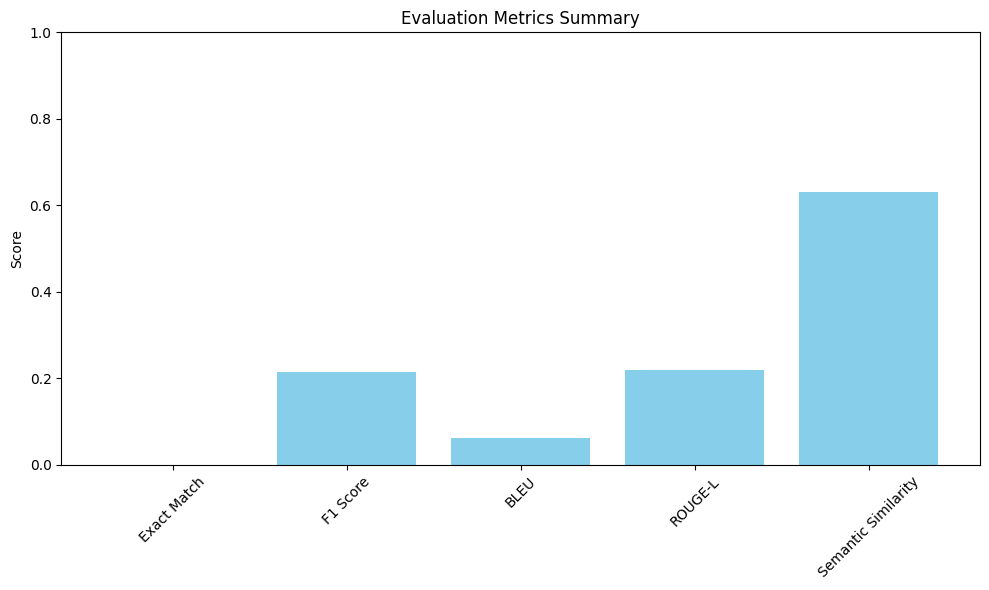

Evaluation Summary:
Exact Match: 0.0000
F1 Score: 0.2132
BLEU: 0.0613
ROUGE-L: 0.2195
Semantic Similarity: 0.6299


In [89]:
df_merged_c, custom_summary =get_evals_img_onlyt(df_merged_c)

In [90]:
# Example data
labels = list(text_only_summary.keys())
x = np.arange(len(labels))  # label positions
width = 0.25  # width of each bar

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, text_only_summary.values(), width, label='Text-only', color='skyblue', alpha=0.6)
plt.bar(x + width/2, vis_only_summary.values(), width, label='Visual-only', color='orange', alpha=0.6)
plt.bar(x + 3*width/2, custom_summary.values(), width, label='ReAlignQA', color='red', alpha=0.6)

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Evaluation Metrics Summary")
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'text_only_summary' is not defined

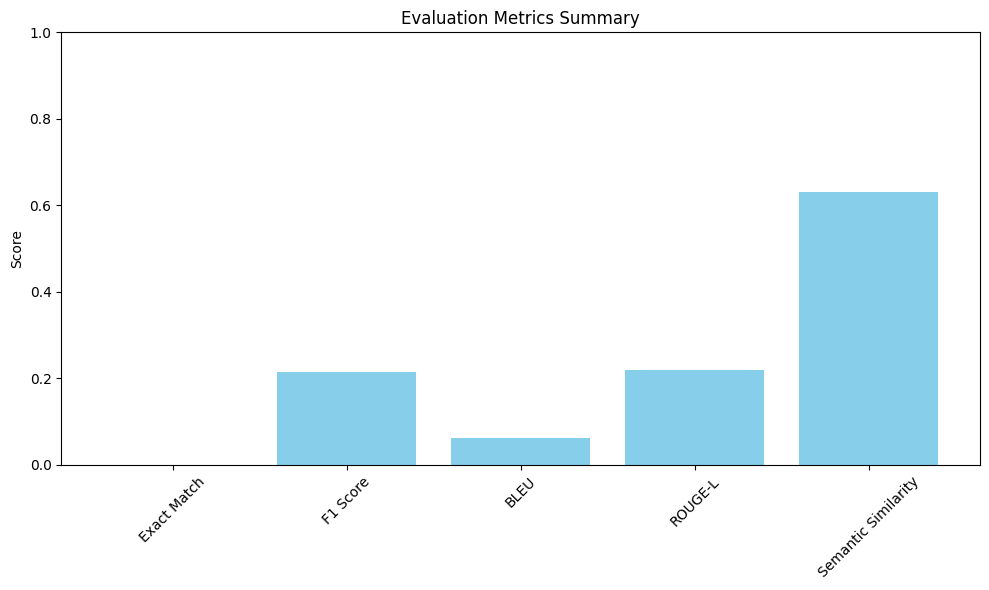

Evaluation Summary:
Exact Match: 0.0000
F1 Score: 0.2132
BLEU: 0.0613
ROUGE-L: 0.2195
Semantic Similarity: 0.6299


In [49]:
df_merged_c, custom_summary =get_evals_img_onlyt(df_merged_c)

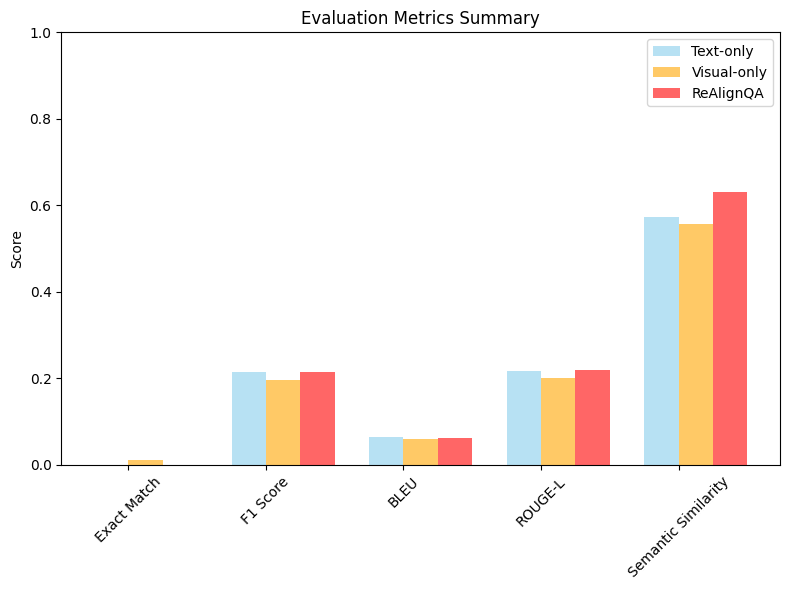

In [64]:
# Example data
labels = list(text_only_summary.keys())
x = np.arange(len(labels))  # label positions
width = 0.25  # width of each bar

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, text_only_summary.values(), width, label='Text-only', color='skyblue', alpha=0.6)
plt.bar(x + width/2, vis_only_summary.values(), width, label='Visual-only', color='orange', alpha=0.6)
plt.bar(x + 3*width/2, custom_summary.values(), width, label='ReAlignQA', color='red', alpha=0.6)

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Evaluation Metrics Summary")
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

---

In [54]:
# Since there was no index column for ground truth df(to be used in merging)
text_gt = index_add_to_gold_truth_df(gold_truth_csv_path = '../../../../Data/VisDoM-main/spiqa/spiqa.csv')
text_gt.head(3)

,index,q_id,doc_id,old_question,answer,doc_path,documents,rationale,reference_figure,paper_title,paper_abstract,caption,question
0,0,spiqa_0,1805.01216v3,How does Figure 9 in the paper *Disentangling ...,\n\nThe pre-processed SMD Navigate data combi...,1805.01216v3.pdf,"['1805.01216v3.pdf', '1705.09296v2.pdf', '1705...",\n\nThe figure shows two tables. The top tabl...,1805.01216v3-Figure9-1.png,Disentangling Language and Knowledge in Task-O...,The Knowledge Base (KB) used for real-world ap...,Figure 9: Pre-processing of SMD Navigate data ...,\n\nWhat is the difference between the origin...
1,1,spiqa_1,1805.07567v2,Referring to the figure that illustrates the i...,\n\nIncreasing the value of β2 decreases the ...,1805.07567v2.pdf,"['1805.07567v2.pdf', '1802.07222v1.pdf', '1811...",\n\nThe figure shows that the precision curve...,1805.07567v2-Figure6-1.png,Optimizing the F-measure for Threshold-free Sa...,Current CNN-based solutions to salient object ...,"Precision, Recall, F-measure of model trained ...",\n\nWhat is the effect of increasing the valu...
2,2,spiqa_2,1603.00286v5,How does Figure 1 in the paper illustrate the ...,"\n\nIn 2-D division, there may be unallocated...",1603.00286v5.pdf,"['1603.00286v5.pdf', '1705.07164v8.pdf', '1811...",\n\nFigure 1 shows an example of a 2-D cake w...,1603.00286v5-Figure1-1.png,Redividing the Cake,The paper considers fair allocation of resourc...,"Fig. 1 With geometric constraints, an efficien...",\n\nWhy does the author state that there is a...


# Side by side comparison

In [96]:
df_merged_all = merge_dfs_by(df_gold=text_gt[0:50] ,df_bot=df_merged_c, index='index')
# df_merged_c.head(2)


In [97]:
# First, define the key columns for alignment (common identifiers)
key_columns = ['index', 'q_id', 'doc_id', 'doc_path', 'reference_figure']

# Columns to keep from df_merged
cols_merged = key_columns + ['old_question', 'answer', 'response']
df_1 = df_merged[cols_merged].copy()
df_1.rename(columns={
    'old_question': 'aug_question',
    # 'answer': 'gold_answer_1',
    'response': 'response_text'
}, inplace=True)

# Columns to keep from df_merged_v
cols_merged_v = key_columns + ['question_x', 'answer', 'response']
df_2 = df_merged_v[cols_merged_v].copy()
df_2.rename(columns={
    'question_x': 'old_question',
    'answer': 'gold_answer',
    'response': 'response_vision'
}, inplace=True)

# Merge both based on the key columns
df_combined = pd.merge(df_1, df_2, on=key_columns, how='inner')


In [56]:
df_combined.sample(4)

,index,q_id,doc_id,doc_path,reference_figure,aug_question,answer,response_text,old_question,gold_answer,response_vision
119,89,spiqa_89,1805.01216v3,1805.01216v3.pdf,1805.01216v3-Figure2-1.png,"Based on Figure 2 of the BoSsNet paper, how do...",The encoder understands the last user utteranc...,The provided context does not specify how the ...,How does the encoder understand the last user ...,The encoder understands the last user utteranc...,The image shows that there is a flowchart with...
374,344,spiqa_345,1705.02946v3,1705.02946v3.pdf,1705.02946v3-Table1-1.png,What is the upper bound on query complexity fo...,O(n^3 / ε),The provided context does not detail any speci...,What is the upper bound on the query complexit...,O(n^3 / ε),"In this table, the upper bound on the query co..."
67,37,spiqa_37,1704.07121v2,1704.07121v2.pdf,1704.07121v2-Figure1-1.png,How does Figure 1 in the paper illustrate how ...,The shortcuts in the Visual7W dataset can be r...,The provided context does not directly illustr...,How can the shortcuts in the Visual7W dataset ...,The shortcuts in the Visual7W dataset can be r...,"In the image, you can see a train coming down ..."
442,412,spiqa_413,1708.02153v2,1708.02153v2.pdf,1708.02153v2-Table1-1.png,"In the context of the ""Shifted"" images shown i...",LIME appears to place the most emphasis on spe...,"In the context, there is no explicit informati...",Which explanation method seems to place the mo...,LIME appears to place the most emphasis on spe...,Parzen


In [97]:
df_combined[['response_text',	'old_question'	,'gold_answer',	'response_vision']]

,response_text,old_question,gold_answer,response_vision
0,Answered: Yes\nReason for answer: Figure 9 in ...,\n\nWhat is the difference between the origin...,\n\nThe pre-processed SMD Navigate data combi...,The image presents a comparison of two tables ...
1,Answered: Yes\nReason for answer: Figure 9 in ...,\n\nWhat is the difference between the origin...,\n\nThe pre-processed SMD Navigate data combi...,The image presents a comparison of two tables ...
2,Answered: Yes\nReason for answer: Figure 9 in ...,\n\nWhat is the difference between the origin...,\n\nThe pre-processed SMD Navigate data combi...,The image presents a comparison of two tables ...
3,Answered: Yes\nReason for answer: Figure 9 in ...,\n\nWhat is the difference between the origin...,\n\nThe pre-processed SMD Navigate data combi...,The image presents a comparison of two tables ...
4,Answered: Yes\nReason for answer: Increasing β...,\n\nWhat is the effect of increasing the valu...,\n\nIncreasing the value of β2 decreases the ...,"In the image, there is a graph showing the rel..."
...,...,...,...,...
611,Answered: Yes\nReason for answer: In low-power...,Why is relying on fragmentation effective for ...,Relying on fragmentation is effective because ...,"In the image, there is a table with numbers in..."
612,Answered: Yes\nReason for answer: The MLE-base...,Why is the model discouraged even though the g...,The model is discouraged because it is trained...,"Based on Table 1, the MLE-based training proce..."
613,Answered: Yes\nReason for answer: The provided...,Why is the number of demonstrations after the ...,The passage mentions that additional trajector...,"Based on the image, it is not clear from Table..."
614,Answered or not: Yes(answered)\nReason for ans...,Why is the optimal threshold chosen to be at t...,The region around the mode of the histogram mo...,The optimal threshold is placed at the right m...


# qualitative Comparison

In [7]:
# Notebooks\25\VQA_RAG\Evaluation\merged_for_evaluation.csv

realign_df = pd.read_csv("../../VQA_RAG/Evaluation/merged_for_evaluation.csv")

In [9]:
realign_df.head(3)

,index,q_id,doc_id,old_question,answer,doc_path,documents,rationale,reference_figure,paper_title,paper_abstract,caption_x,question_x,question_y,caption_y,image,response
0,0,spiqa_0,1805.01216v3,How does Figure 9 in the paper *Disentangling ...,\n\nThe pre-processed SMD Navigate data combi...,1805.01216v3.pdf,"['1805.01216v3.pdf', '1705.09296v2.pdf', '1705...",\n\nThe figure shows two tables. The top tabl...,1805.01216v3-Figure9-1.png,Disentangling Language and Knowledge in Task-O...,The Knowledge Base (KB) used for real-world ap...,Figure 9: Pre-processing of SMD Navigate data ...,\n\nWhat is the difference between the origin...,How does Figure 9 in the paper *Disentangling ...,Figure 9: Pre-processing of SMD Navigate data ...,../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_...,"Figure 9 in the paper ""Disentangling Language ..."
1,1,spiqa_1,1805.07567v2,Referring to the figure that illustrates the i...,\n\nIncreasing the value of β2 decreases the ...,1805.07567v2.pdf,"['1805.07567v2.pdf', '1802.07222v1.pdf', '1811...",\n\nThe figure shows that the precision curve...,1805.07567v2-Figure6-1.png,Optimizing the F-measure for Threshold-free Sa...,Current CNN-based solutions to salient object ...,"Precision, Recall, F-measure of model trained ...",\n\nWhat is the effect of increasing the valu...,Referring to the figure that illustrates the i...,"Precision, Recall, F-measure of model trained ...",../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_...,Increasing the value of β2 in the salient obje...
2,2,spiqa_2,1603.00286v5,How does Figure 1 in the paper illustrate the ...,"\n\nIn 2-D division, there may be unallocated...",1603.00286v5.pdf,"['1603.00286v5.pdf', '1705.07164v8.pdf', '1811...",\n\nFigure 1 shows an example of a 2-D cake w...,1603.00286v5-Figure1-1.png,Redividing the Cake,The paper considers fair allocation of resourc...,"Fig. 1 With geometric constraints, an efficien...",\n\nWhy does the author state that there is a...,How does Figure 1 in the paper illustrate the ...,"Fig. 1 With geometric constraints, an efficien...",../Data/spiqa/test-A/SPIQA_testA_Images/SPIQA_...,Figure 1 in the paper demonstrates the differe...


In [13]:
realign_df.loc[0]
# realign_df.loc[0]['response']

index                                                               0
q_id                                                          spiqa_0
doc_id                                                   1805.01216v3
old_question        How does Figure 9 in the paper *Disentangling ...
answer               \n\nThe pre-processed SMD Navigate data combi...
doc_path                                             1805.01216v3.pdf
documents           ['1805.01216v3.pdf', '1705.09296v2.pdf', '1705...
rationale            \n\nThe figure shows two tables. The top tabl...
reference_figure                           1805.01216v3-Figure9-1.png
paper_title         Disentangling Language and Knowledge in Task-O...
paper_abstract      The Knowledge Base (KB) used for real-world ap...
caption_x           Figure 9: Pre-processing of SMD Navigate data ...
question_x           \n\nWhat is the difference between the origin...
question_y          How does Figure 9 in the paper *Disentangling ...
caption_y           

response        Figure 9 in the paper "Disentangling Language and Knowledge in Task-Oriented Dialogs" depicts the transformation process between the original and pre-processed SMD Navigate datasets. The visualization is presented as a table with two columns - one for the "Original SMD Navigate Dataset" and another for the "Preprocessed SMD Navigate Dataset." Each column contains several rows of words or phrases, with an arrow pointing from the left to the right. This visual representation illustrates how pre-processing simplifies and focuses on essential information for improved navigation by eliminating unnecessary details from the original dataset.
caption_x                                                                                                                                                                                                                                                                                                                                            

In [29]:
row_index =0
realign_df.loc[row_index][['image']][0]
im = Image.open("../../../"+realign_df.loc[row_index][['image']][0])
im.show()

C:\Users\Lisara\AppData\Local\Temp\ipykernel_11612\3387929722.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  realign_df.loc[row_index][['image']][0]
C:\Users\Lisara\AppData\Local\Temp\ipykernel_11612\3387929722.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = Image.open("../../../"+realign_df.loc[row_index][['image']][0])


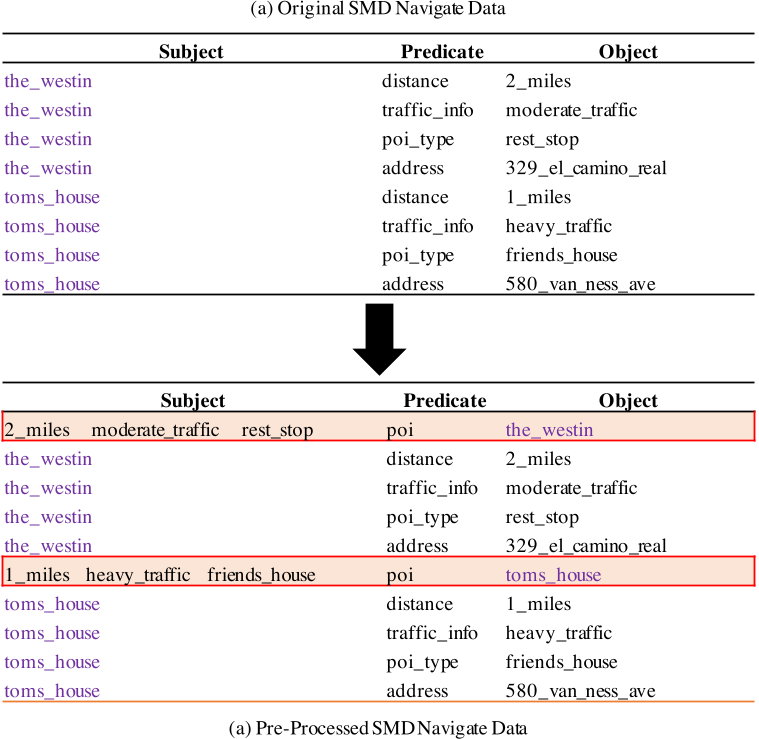

In [32]:
im

In [ ]:
Image.open("../../../"+"../Data")

In [ ]:
row = realign_df.loc[0]
print('response:', row.loc['response'])

Figure 9 in the paper "Disentangling Language and Knowledge in Task-Oriented Dialogs" depicts the transformation process between the original and pre-processed SMD Navigate datasets. The visualization is presented as a table with two columns - one for the "Original SMD Navigate Dataset" and another for the "Preprocessed SMD Navigate Dataset." Each column contains several rows of words or phrases, with an arrow pointing from the left to the right. This visual representation illustrates how pre-processing simplifies and focuses on essential information for improved navigation by eliminating unnecessary details from the original dataset.


In [99]:
def comparison(df,row_index):
    row = realign_df.loc[row_index]
    # pd.set_option('display.max_colwidth', None)
    row[['response','caption_x','question_x','answer', 'old_question']]
    print('response:', row.loc['response'])
    print('caption:', row.loc['caption_x'])
    print('old question:', row.loc['question_x'])
    print('question:', row.loc['old_question'])
    print('gold truth:', row.loc['answer'])
    
    return Image.open("../../../"+row[['image']][0])

response: Based on the provided figure and considering that the visual model has indicated that it doesn't have sufficient data for an accurate comparison, I cannot definitively state the differences in the temporal patterns of phenotype magnitude, shape, and periodicity between the sickle cell anemia patient and the leukemia patient as described in the "COPA: Constrained PARAFAC2 for Sparse & Large Datasets" paper. To provide a detailed comparison, I would need specific data or information about the patterns observed by each method (COPA, Helwig, and SPARTan) for both patients, which is not available from this visual model's response.
caption: The temporal patterns extracted for two patients by COPA , Helwig, and SPARTan. The first row is associated with a patient who has sickle cell anemia while the second row is for a patient with Leukemia.
old question: How do the temporal patterns of phenotype magnitude differ between sickle cell anemia and leukemia patients?
question: Based on th

C:\Users\Lisara\AppData\Local\Temp\ipykernel_11612\2912970614.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return Image.open("../../../"+row[['image']][0])


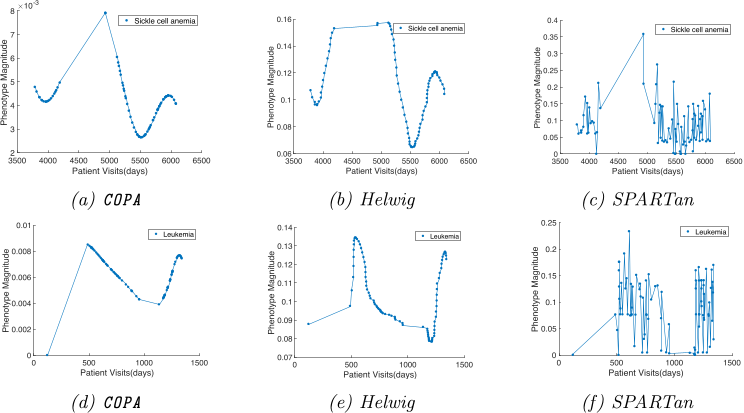

In [100]:
im = comparison(realign_df,44)
im

response: Based on the provided information from Figure (b) in the comprehensive study of the ACNN model, it appears that the model achieves its highest accuracy compared to all others within the category of question types in the WikiQA dataset. However, for a more accurate interpretation, it would be ideal to have access to the specific accuracy values for each question type.
caption: Comprehensive study of the proposed ACNN framework, including (a) the number of filters (Yelp dataset), and (b) performance vs question types (WikiQA dataset), and (c) t-SNE visualization of learned filter weights (DBpedia dataset).
old question: Based on the figure, which type of question does ACNN perform the best on?
question: Looking at the performance results in Figure (b), which specific question type within the WikiQA dataset does the ACNN model achieve its highest accuracy compared to all others?
gold truth: ACNN performs best on "Who" questions.


C:\Users\Lisara\AppData\Local\Temp\ipykernel_11612\2044624872.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return Image.open("../../../"+row[['image']][0])


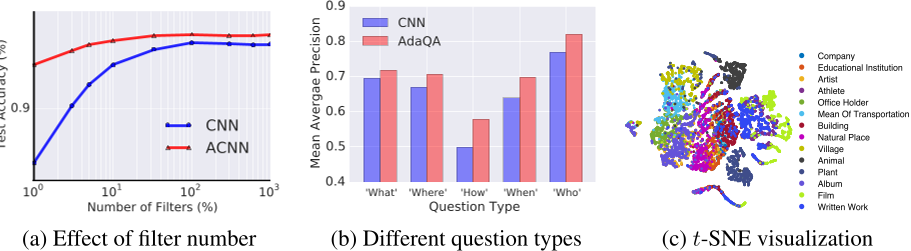

In [41]:
im = comparison(14)
im

In [ ]:
def comparison_text_im(df,row_index):
    row = realign_df.loc[row_index]
    # pd.set_option('display.max_colwidth', None)
    row[['response','caption_x','question_x','answer', 'old_question']]
    print('response:', row.loc['response'])
    print('caption:', row.loc['caption_x'])
    print('old question:', row.loc['question_x'])
    print('question:', row.loc['old_question'])
    print('gold truth:', row.loc['answer'])
    
    return Image.open("../../../"+row[['image']][0])

In [101]:
df_combined.columns

Index(['index', 'q_id', 'doc_id', 'doc_path', 'reference_figure',
       'aug_question', 'answer', 'response_text', 'old_question',
       'gold_answer', 'response_vision'],
      dtype='object')

## BLEU Score For Columns

In [103]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to calculate BLEU score
def calculate_bleu(reference, hypothesis):
    reference = [reference.split()]  # needs to be a list of list of tokens
    hypothesis = hypothesis.split()
    return sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method1)

In [ ]:
# Example DataFrame
data = {
    'reference': ['the cat is on the mat', 'there is a cat', 'hello world',*candidates],
    'hypothesis': ['the cat is on mat', 'there is cat', 'hello planet',*references]
}
# df = pd.DataFrame(data)
# Calculate BLEU scores and store them
bleu_scores = []
for idx, row in pd.DataFrame(data).iterrows():
    score_ = calculate_bleu(row['reference'], row['hypothesis'])
    bleu_scores.append({'index': idx, 'bleu_score': score_})
# Create new DataFrame with scores
bleu_df = pd.DataFrame(bleu_scores)

print(bleu_df)

   index  bleu_score
0      0    0.578930
1      1    0.190536
2      2    0.149535
3      3    0.001928


### BERTScore

In [115]:
candidates = ["response: The two-dimensional parameter space depicted in the provided image represents the variations in the initial conditions of a liquid drop. The position of the drop along the x-axis is represented by α1, and its size is represented by α2. This setup consists of multiple two-dimensional simulations that allow for exploration of how different positions and sizes impact the behavior of the liquid drop.In particular, the height or position of the drop (represented on the vertical axis) affects factors like evaporation rate and gravitational forces, while the width or size of the drop (represented on the horizontal axis) influences the contact angle between the drop and a surface or its spreading on a flat surface.By examining the variations in both dimensions within this parameter space, we can gain insights into how different initial conditions will affect the overall dynamics of the liquid drop throughout various processes such as drying, cooling, or condensation. This representation is crucial for understanding and predicting the behavior of liquid drops under diverse conditions."]
references = ["The initial conditions of the simulations vary in two dimensions: the position of the liquid drop along the x-axis (α1) and the size of the drop (α2)."]

P, R, F1 = score(candidates, references, lang="en", model_type="bert-base-uncased")
print(f"Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")


Precision: 0.5599, Recall: 0.7647, F1: 0.6464


### BERTScore

In [ ]:
P, R, F1 = score(
    candidates,
    references,
    model_type="allenai/scibert_scivocab_uncased",
    lang="en",  # still "en" even though it's SciBERT
    rescale_with_baseline=True  # Optional: better calibration
)
print(f"Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

Precision: 0.6018, Recall: 0.7709, F1: 0.6759


In [ ]:
# Assuming your dataframe has columns: 'reference' and 'candidate'
references = df['reference'].tolist()
candidates = df['candidate'].tolist()

P, R, F1 = score(
    candidates,
    references,
    model_type='allenai/scibert_scivocab_uncased',
    lang='en',
    rescale_with_baseline=True
)

df['SciBERT_P'] = P.tolist()
df['SciBERT_R'] = R.tolist()
df['SciBERT_F1'] = F1.tolist()
